In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from dataclasses import dataclass
from typing import Any, List, Tuple, Dict
from pandas import DataFrame

In [4]:
@dataclass
class City:
    index : int
    X : float
    Y : float

@dataclass
class Item:
    index : int
    Profit : int
    Weight : int
    Node : int
    
@dataclass
class TTP:
    Name :str = None
    DTYPE : str = None
    Dimension : int = 0
    ITEMS : int = 0
    CAPACITY : int = 0
    MIN_SPEED : float = 0
    MAX_SPEED : float = 0
    RENTING_RATIO : float = 0
    EDGE_W : str = None
    NODE : List[City] = None
    ITEM : List[Item] = None

In [5]:
def read_problem(file_path:str):
    with open(file_path,'r') as file:
        lines = file.readlines()
    
    data = TTP(NODE=[],ITEM=[])
    
    for i , line in enumerate(lines):
        if line.startswith("PROBLEM NAME"):
            data.Name = line.split(':')[-1].strip()
        elif line.startswith("KNAPSACK DATA TYPE"):
            data.DTYPE = line.split(':')[-1].strip()
        elif line.startswith("DIMENSION"):
            data.Dimension = int(line.split(':')[-1].strip())
        elif line.startswith("NUMBER OF ITEMS"):
            data.ITEMS = int(line.split(':')[-1].strip())
        elif line.startswith("CAPACITY OF KNAPSACK"):
            data.CAPACITY = int(line.split(':')[-1].strip())
        elif line.startswith("MIN SPEED"):
            data.MIN_SPEED = float(line.split(':')[-1].strip())
        elif line.startswith("MAX SPEED"):
            data.MAX_SPEED = float(line.split(':')[-1].strip())
        elif line.startswith("RENTING RATIO"):
            data.RENTING_RATIO = float(line.split(':')[-1].strip())
        elif line.startswith("EDGE_WEIGHT_TYPE"):
            data.EDGE_W = line.split(':')[-1].strip()
        elif line.startswith("NODE_COORD_SECTION"):
            for j in range(1,data.Dimension+1):
                node = lines[i+j].split()
                data.NODE.append(City(index=int(node[0]),X=float(node[1]),Y=float(node[2])))
        elif line.startswith("ITEMS SECTION"):
            for j in range(1,data.ITEMS+1):
                item = lines[i+j].split()
                data.ITEM.append(
                    Item(int(item[0]),int(item[1]),int(item[2]),int(item[3]))
                )
        else:
            pass
    
    return data

def generate_ttp_solution(number_of_cities: int, items: List[Item], knapsack_capacity: int) -> Tuple[List[int], List[int]]:
    # Generate a random path (tour)
    path = np.random.permutation(number_of_cities) + 1

    # Initialize knapsack plan with no items picked
    plan = [0] * len(items)
    current_weight = 0

    # Randomly decide to pick up items considering the knapsack capacity
    for i, item in enumerate(items):
        item_weight = item.Weight
        if current_weight + item_weight <= knapsack_capacity:
            decision = np.random.choice([0, 1])
            plan[i] = decision
            current_weight += item_weight * decision

    return path.tolist(), plan

def euclidean_distance(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    return math.ceil(np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2))

def calculate_time_and_profit(solution: List[int], plan: List[int], nodes: List[City], items: List[Item], min_speed, max_speed, max_weight):
    total_time = 0
    total_profit = 0
    current_weight = 0

    # Calculate the total travel time
    for i in range(len(solution)):
        current_city_index = solution[i]
        next_city_index = solution[0] if i == len(solution) - 1 else solution[i + 1]

        current_city = nodes[current_city_index - 1]
        next_city = nodes[next_city_index - 1]

        

        # Update current weight based on items picked at the current city
        for item, is_picked in zip(items, plan):
            if is_picked and item.Node == current_city_index:
                current_weight += item.Weight

        # Calculate speed based on current weight
        speed = max_speed - (current_weight / max_weight) * (max_speed - min_speed)
        speed = max(speed, min_speed)  # Ensure speed doesn't drop below minimum

        # Distance between current city and next city
        distance = euclidean_distance((current_city.X, current_city.Y), (next_city.X, next_city.Y))

        # Update time with time to next city
        total_time += distance / speed

        if current_weight > max_weight:
            return np.Inf , 0.0

    # Calculate total profit from picked items
    for item, is_picked in zip(items, plan):
        if is_picked:
            total_profit += item.Profit


    return total_time, total_profit

In [6]:
path = './datasets/test-example-n4.txt'
path2 = './datasets/a280-n1395.txt'
data = read_problem(file_path=path2)
max_weight = data.CAPACITY
max_speed = data.MAX_SPEED
min_speed = data.MIN_SPEED
dimension = data.Dimension
nitem = data.ITEMS
node = data.NODE
item = data.ITEM
renting_ratio = data.RENTING_RATIO

In [7]:
max_speed, min_speed , dimension, nitem, renting_ratio

(1.0, 0.1, 280, 1395, 72.7)

In [8]:
@dataclass
class Phenome:
    time : float
    profit : float
    net_profit : float = 0

    def __post_init__(self):
        self.net_profit = self.profit - (self.time*renting_ratio)

@dataclass
class Chromosome:
    path : List[int]
    plan : List[int]
    phenome : Phenome = None

    def __post_init__(self):
        self.phenome = Phenome(
            *calculate_time_and_profit(
                self.path,self.plan,node,item,min_speed,max_speed,max_weight))

In [10]:
data

TTP(Name='a280-TTP', DTYPE='uncorrelated, similar weights', Dimension=280, ITEMS=1395, CAPACITY=637010, MIN_SPEED=0.1, MAX_SPEED=1.0, RENTING_RATIO=72.7, EDGE_W='CEIL_2D', NODE=[City(index=1, X=288.0, Y=149.0), City(index=2, X=288.0, Y=129.0), City(index=3, X=270.0, Y=133.0), City(index=4, X=256.0, Y=141.0), City(index=5, X=256.0, Y=157.0), City(index=6, X=246.0, Y=157.0), City(index=7, X=236.0, Y=169.0), City(index=8, X=228.0, Y=169.0), City(index=9, X=228.0, Y=161.0), City(index=10, X=220.0, Y=169.0), City(index=11, X=212.0, Y=169.0), City(index=12, X=204.0, Y=169.0), City(index=13, X=196.0, Y=169.0), City(index=14, X=188.0, Y=169.0), City(index=15, X=196.0, Y=161.0), City(index=16, X=188.0, Y=145.0), City(index=17, X=172.0, Y=145.0), City(index=18, X=164.0, Y=145.0), City(index=19, X=156.0, Y=145.0), City(index=20, X=148.0, Y=145.0), City(index=21, X=140.0, Y=145.0), City(index=22, X=148.0, Y=169.0), City(index=23, X=164.0, Y=169.0), City(index=24, X=172.0, Y=169.0), City(index=25, 

genetic algorithm operators

In [11]:
def tournament_selection(population: List[int], tournament_size: int) -> Chromosome:
    """
    Selects a single Chromosome from the population using tournament selection.

    :param population: An instance of the Population class containing Chromosomes.
    :param tournament_size: The number of Chromosomes to be selected for each tournament.
    :return: The winning Chromosome with the highest net profit.
    """
    # Ensure the tournament size is not larger than the population size
    tournament_size = min(tournament_size, len(population))
    
    # Randomly select 'tournament_size' individuals from the population
    tournament_contestants = np.random.choice(population, size=tournament_size, replace=False)
    
    # Determine the winner based on the highest net profit
    winner = max(tournament_contestants, key=lambda chromo: chromo.phenome.net_profit)
    
    return winner

def ordered_crossover(parent1: Chromosome, parent2: Chromosome) -> Tuple[Chromosome, Chromosome]:
    # Select crossover points for the path
    start, end = sorted(np.random.choice(range(len(parent1.path)), 2))

    # Create segments from parents
    parent1_segment = parent1.path[start:end]
    parent2_segment = parent2.path[start:end]

    # Create offspring paths excluding parent segments
    offspring1_path = [city for city in parent2.path if city not in parent1_segment]
    offspring2_path = [city for city in parent1.path if city not in parent2_segment]

    # Insert parent segments into offspring paths
    offspring1_path[start:start] = parent1_segment
    offspring2_path[start:start] = parent2_segment

    # For the plan, using a simple one-point crossover
    crossover_point = np.random.randint(1, len(parent1.plan) - 1)
    offspring1_plan = parent1.plan[:crossover_point] + parent2.plan[crossover_point:]
    offspring2_plan = parent2.plan[:crossover_point] + parent1.plan[crossover_point:]

    # Create new Chromosome instances for offspring
    offspring1 = Chromosome(offspring1_path, offspring1_plan)
    offspring2 = Chromosome(offspring2_path, offspring2_plan)

    return offspring1, offspring2

def inversion_mutation(chromosome: Chromosome):
    # Ensure there are at least two elements in the path
    if len(chromosome.path) < 2:
        return chromosome
    path = chromosome.path.copy()
    plan = chromosome.plan.copy()
    # Choose two distinct random positions in the path
    pos1, pos2 = sorted(np.random.choice(range(len(chromosome.path)), 2))

    # Invert the order of elements between pos1 and pos2
    path[pos1:pos2 + 1] = reversed(path[pos1:pos2 + 1])
    plan[pos1:pos2 + 1] = reversed(plan[pos1:pos2 + 1])

    return Chromosome(path,plan)

def replace_weakest(population : List[Chromosome], candidates:Chromosome):
    keys = [x.phenome.net_profit for x in population]
    weakest_index = np.argmin(keys)

    if candidates.phenome.net_profit > population[weakest_index].phenome.net_profit:
        population[weakest_index] = candidates 

    return population


In [35]:
Chromosome(*generate_ttp_solution(dimension, item, max_weight))

Chromosome(path=[171, 271, 90, 60, 7, 233, 193, 256, 162, 142, 159, 117, 150, 273, 55, 65, 228, 260, 265, 163, 43, 131, 107, 87, 40, 164, 146, 151, 241, 86, 77, 109, 239, 207, 238, 258, 168, 130, 243, 32, 181, 113, 248, 251, 38, 15, 56, 127, 152, 75, 191, 194, 184, 89, 63, 10, 274, 25, 85, 110, 51, 237, 153, 68, 81, 129, 84, 88, 111, 232, 14, 70, 257, 76, 26, 124, 190, 30, 99, 279, 71, 23, 195, 165, 101, 123, 230, 222, 203, 219, 22, 1, 204, 170, 231, 270, 176, 80, 83, 182, 208, 37, 125, 169, 104, 29, 8, 216, 41, 73, 223, 5, 269, 272, 46, 134, 250, 108, 121, 235, 126, 224, 174, 267, 35, 242, 172, 140, 209, 215, 47, 13, 229, 161, 178, 133, 173, 276, 277, 58, 91, 33, 158, 122, 180, 92, 96, 278, 189, 268, 262, 261, 18, 148, 6, 93, 64, 212, 187, 50, 78, 160, 147, 103, 105, 34, 98, 116, 82, 149, 45, 185, 186, 218, 177, 211, 102, 59, 57, 24, 4, 54, 192, 253, 244, 97, 220, 196, 20, 19, 94, 280, 28, 202, 106, 245, 206, 236, 48, 214, 156, 27, 179, 264, 217, 141, 112, 17, 12, 145, 200, 2, 52, 11,

In [36]:
max_generation = 100000
max_pop = 1000
tour_size = 10
best_fit = []
avg_fit = []
best_chromosome = None

start = time.time()

# Initial population
population = [Chromosome(*generate_ttp_solution(dimension, item, max_weight)) for _ in range(max_pop)]
current_best = sorted(population, key=lambda c: c.phenome.net_profit)[-1]
best_fit.append(current_best.phenome.net_profit)
avg_fit.append(sum(c.phenome.net_profit for c in population) / len(population))
best_chromosome = current_best

# Evolution loop
for i in range(max_generation):
    p1 = tournament_selection(population, tour_size)
    p2 = tournament_selection(population, tour_size)
    if np.random.rand() < 1:
        o1, o2 = ordered_crossover(p1, p2)
    else:
        o1, o2 = p1,p2
    if np.random.rand() < 1:
        o1 = inversion_mutation(o1)
        o2 = inversion_mutation(o2)
    population = replace_weakest(population, o1)
    population = replace_weakest(population, o2)

    current_best = sorted(population, key=lambda c: c.phenome.net_profit)[-1]
    best_fit.append(current_best.phenome.net_profit)
    avg_fit.append(sum(c.phenome.net_profit for c in population) / len(population))

    # Update the best chromosome if a better one is found
    if current_best.phenome.net_profit > best_chromosome.phenome.net_profit:
        best_chromosome = current_best

end = time.time()
time_exc = end - start

# Final best chromosome
best_chromosome = sorted(population, key=lambda c: c.phenome.net_profit)[-1]

In [37]:
print(f"dataset: {path2.split('/')[-1].split('.')[0]}")
print(f"======MetaData======")
print(f"name : {data.Name}")
print(f"num dimension : {data.Dimension}")
print(f"num item : {data.ITEMS}")
print(f"max weight : {data.CAPACITY}")
print(f"speed range: [{data.MIN_SPEED},{data.MAX_SPEED}]")
print(f"renting ratio : {data.RENTING_RATIO}")
print(f"======experiment result======")
print(f"time executed: {time_exc}")
print(f"best path : {best_chromosome.path}")
print(f"best plan : {best_chromosome.plan}")
print(f"time : {best_chromosome.phenome.time}")
print(f"profit : {best_chromosome.phenome.profit}")
print(f"Net profit : {best_chromosome.phenome.net_profit}")

dataset: a280-n1395
======MetaData======
name : a280-TTP
num dimension : 280
num item : 1395
max weight : 637010
speed range: [0.1,1.0]
renting ratio : 72.7
======experiment result======
time executed: 10222.995016336441
best path : [1, 230, 252, 209, 208, 221, 192, 185, 195, 220, 197, 194, 191, 158, 178, 186, 193, 219, 222, 213, 207, 201, 200, 202, 3, 259, 256, 205, 204, 216, 210, 226, 225, 224, 261, 262, 8, 242, 249, 241, 231, 214, 206, 135, 154, 121, 125, 129, 130, 131, 20, 176, 151, 113, 96, 105, 165, 180, 142, 147, 182, 149, 143, 144, 189, 184, 157, 107, 83, 63, 47, 66, 114, 65, 54, 86, 76, 78, 102, 87, 88, 111, 117, 126, 35, 50, 32, 6, 271, 274, 14, 270, 140, 218, 217, 223, 212, 229, 232, 280, 16, 15, 268, 24, 25, 21, 28, 34, 122, 127, 23, 22, 31, 29, 58, 74, 67, 70, 68, 52, 55, 57, 162, 161, 119, 123, 124, 41, 120, 153, 174, 101, 97, 90, 93, 109, 118, 53, 156, 42, 43, 71, 75, 82, 84, 112, 163, 164, 168, 169, 106, 187, 139, 128, 33, 39, 60, 59, 116, 95, 81, 99, 92, 166, 173, 172,

In [39]:
# Define the file path where you want to save the output
output_file_path = "output.txt"

# Open the file for writing
with open(output_file_path, "w") as output_file:
    # Write the dataset information
    output_file.write(f"dataset: {path2.split('/')[-1].split('.')[0]}\n")
    output_file.write("======MetaData======\n")
    output_file.write(f"name : {data.Name}\n")
    output_file.write(f"num dimension : {data.Dimension}\n")
    output_file.write(f"num item : {data.ITEMS}\n")
    output_file.write(f"max weight : {data.CAPACITY}\n")
    output_file.write(f"speed range: [{data.MIN_SPEED},{data.MAX_SPEED}]\n")
    output_file.write(f"renting ratio : {data.RENTING_RATIO}\n")

    # Write the experiment results
    output_file.write("======experiment result======\n")
    output_file.write(f"time executed: {time_exc}\n")
    output_file.write(f"best path : {best_chromosome.path}\n")
    output_file.write(f"best plan : {best_chromosome.plan}\n")
    output_file.write(f"time : {best_chromosome.phenome.time}\n")
    output_file.write(f"profit : {best_chromosome.phenome.profit}\n")
    output_file.write(f"Net profit : {best_chromosome.phenome.net_profit}\n")

# File writing is complete
print(f"Output written to {output_file_path}")


Output written to output.txt


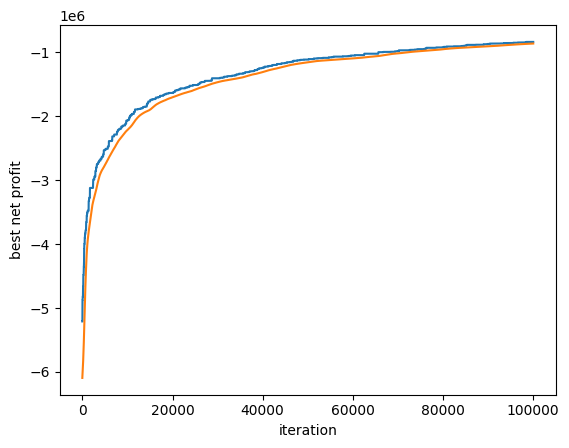

In [38]:
plt.plot(np.arange(len(best_fit)),best_fit)
plt.plot(np.arange(len(avg_fit)),avg_fit)
plt.xlabel("iteration")
plt.ylabel("best net profit")
plt.show()

In [42]:
len(population)

1000

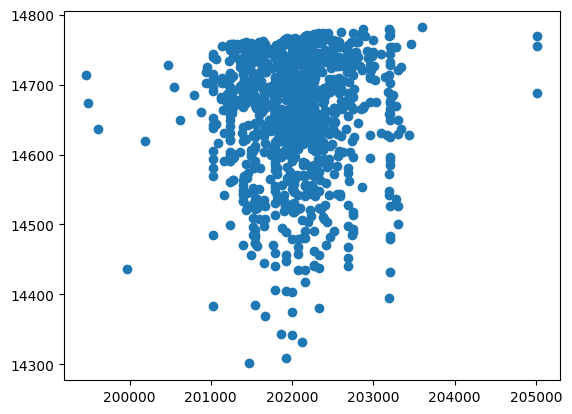

In [43]:
plt.scatter([x.phenome.profit for x in population],[x.phenome.time for x in population])

In [44]:
def is_dominated(chrom1, chrom2):
    """
    Check if chrom1 is dominated by chrom2.
    """
    return (chrom2.phenome.time <= chrom1.phenome.time and chrom2.phenome.profit >= chrom1.phenome.profit) and \
           (chrom2.phenome.time < chrom1.phenome.time or chrom2.phenome.profit > chrom1.phenome.profit)

def find_dominance_flags(population):
    """
    Assign a flag for each chromosome in the population.
    1 for non-dominated, 0 for dominated.
    """
    flags = [1] * len(population)  # Initialize all as non-dominated

    for i, chrom1 in enumerate(population):
        for chrom2 in population:
            if chrom1 != chrom2 and is_dominated(chrom1, chrom2):
                flags[i] = 0  # Mark as dominated
                break  # No need to check further if dominated

    return flags

# Example usage
# Assuming population is already defined
dominance_flags = find_dominance_flags(population)


c:\Users\USER\anaconda3\envs\exeter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\USER\anaconda3\envs\exeter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\USER\anaconda3\envs\exeter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\USER\anaconda3\envs\exeter\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

<Axes: >

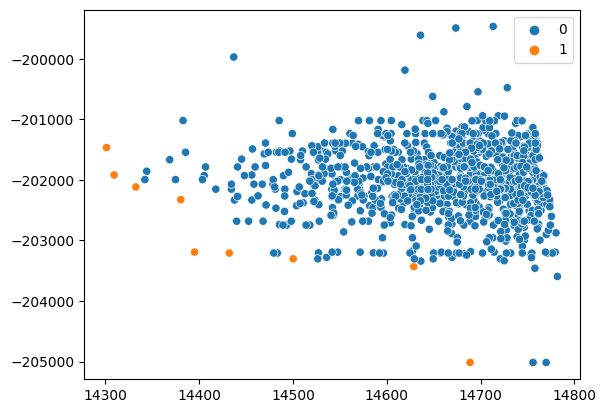

In [49]:
import seaborn as sns

sns.scatterplot(y=[-x.phenome.profit for x in population],x=[x.phenome.time for x in population],hue=dominance_flags)